<a href="https://colab.research.google.com/github/RamenSlayer/StableDiffusionNotebooks/blob/master/image_2_image_using_diffusers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image2Image Pipeline for Stable Diffusion using 🧨 Diffusers 

This notebook shows how to create a custom `diffusers` pipeline for  text-guided image-to-image generation with Stable Diffusion model using  🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

For a general introduction to the Stable Diffusion model please refer to this [colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).



In [ ]:
!nvidia-smi

Fri Dec  9 11:17:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#@title Install dependencies

!pip install diffusers transformers ftfy accelerate
!pip install -qq "ipywidgets>=7,<8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 502 kB 7.0 MB/s 
     |████████████████████████████████| 5.8 MB 62.4 MB/s 
     |████████████████████████████████| 53 kB 1.4 MB/s 
     |████████████████████████████████| 182 kB 53.4 MB/s 
     |████████████████████████████████| 7.6 MB 32.1 MB/s 
     |████████████████████████████████| 1.6 MB 6.5 MB/s 


For some models you need to accept the model license before downloading or using the weights. By default we're using `v1-5`, so you'll need to  visit [its card](https://huggingface.co/runwayml/stable-diffusion-v1-5), read the license and tick the checkbox if you agree. 

Other models I suggest are:

[hakurei/waifu-diffusion](https://huggingface.co/hakurei/waifu-diffusion)

[CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4)

[Linaqruf/anything-v3.0](https://huggingface.co/Linaqruf/anything-v3.0)


To accept, you need to be a registered user in 🤗 Hugging Face Hub, and you'll also need to use an access token for the code to work. For more information on access tokens, please refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).

In [ ]:
#@title Log into huggingface using the token
#@markdown Unneeded for some models.

from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


## Image2Image pipeline.

In [ ]:
#@markdown Import libraries
import inspect
import warnings
from typing import List, Optional, Union

import torch
from torch import autocast
from tqdm.auto import tqdm

from diffusers import StableDiffusionImg2ImgPipeline

Load the pipeline

In [ ]:
device = "cuda"
#@markdown Choose model
model_path = "runwayml/stable-diffusion-v1-5" #@param ["runwayml/stable-diffusion-v1-5", "hakurei/waifu-diffusion", "CompVis/stable-diffusion-v1-4", "Linaqruf/anything-v3.0", "custom"]
#@markdown Touch only if you want to use a model that's not in the list
custom_model = "" #@param {type: 'string'}
use_token = False #@param {type: 'boolean'}
#@markdown Don't touch if you're not sure what it does
revision=None #@param {type: 'string'}
if model_path != "custom":
    if model_path == "runwayml/stable-diffusion-v1-5":
        if revision is None:
            revision = "fp16"
        use_token = True
else:
    model_path = custom_model

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    revision=revision,
    torch_dtype=torch.float16,
    use_auth_token=use_token
)
pipe = pipe.to(device)

#@markdown If you don't want image to blackout when it detects NSFW
enable_nsfw = True #@param {type: 'boolean'}

def dummy_checker(images, **kwargs):
  return images, False

if enable_nsfw:
    pipe.safety_checker = dummy_checker

Downloading:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/342 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.70k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/608M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/284 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/636 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/246M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/472 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/822 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/806 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/609 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
#@title Upload image. { display-mode: "form" }
#@markdown Upload an initial image to preprocess it 
#@markdown before passing to pipeline
from google.colab import files
uploaded = files.upload()
uploaded = list(uploaded.keys())

In [ ]:
#@markdown If uploaded more than one file, print all uploaded files
#@markdown and their indexes
print(*list(map(lambda x: f"{x[0]}: {x[1]}",enumerate(uploaded))), sep="\n")

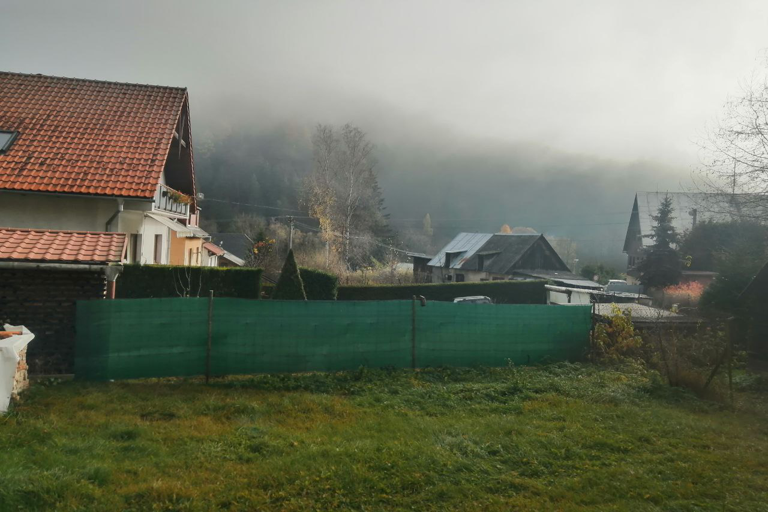

In [ ]:
from PIL import Image

#@markdown If more than one image, choose the index
image_index = 0 #@param {type: 'integer'}

img_path = uploaded[image_index]
init_img = Image.open(img_path).convert("RGB")

#@markdown Sides should be multiples of 64

x_resolution = 512 #@param {type: 'integer'}
y_resolution = 512 #@param {type: 'integer'}
init_img = init_img.resize((x_resolution, y_resolution))
init_img

Define the prompt and run the pipeline.

In [ ]:
prompt = "A 3d render of a village" #@param {type: 'string'}

Here, `strength` is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 allow for lots of variations but will also produce images that are not semantically consistent with the input.

In [ ]:
seed = 1024 #@param {type: 'integer'}
strength = 0.4 #@param {type: 'slider', min: 0, max: 1, step:0.025}
guidance_scale = 0.75 #@param {type: 'slider', min: 0, max: 1, step:0.025}


generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt,
                 image=init_img, # change image to init_image if recieving error
                 strength=0.75,
                 guidance_scale=7.5, 
                 generator=generator,
                 ).images[0]



  0%|          | 0/37 [00:00<?, ?it/s]

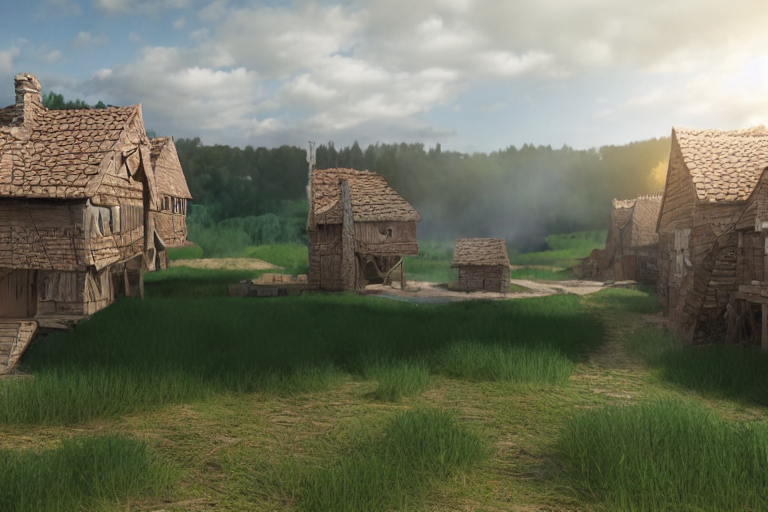

In [ ]:
image

As you can see, when using a lower value for `strength`, the generated image is more closer to the original `init_image`


Now using [LMSDiscreteScheduler](https://huggingface.co/docs/diffusers/api/schedulers#diffusers.LMSDiscreteScheduler)

In [ ]:
from diffusers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear")
pipe.scheduler = lms

In [ ]:
generator = torch.Generator(device=device).manual_seed(1024)
with autocast("cuda"):
    image = pipe(prompt=prompt, init_image=init_img, strength=0.75, guidance_scale=7.5, generator=generator).images[0]

  0%|          | 0/37 [00:00<?, ?it/s]

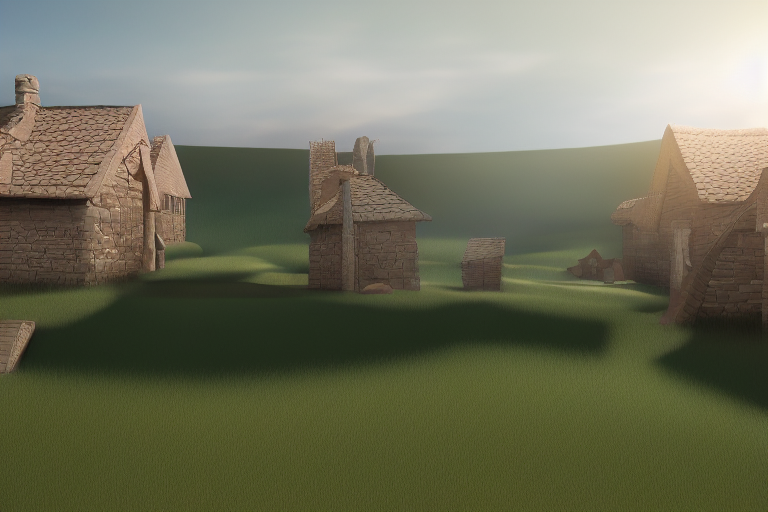

In [ ]:
image